In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [2]:
import analysis as an

In [7]:
# get sqlite cursor and simulation time data
cur = an.cursor('2018_us.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [8]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


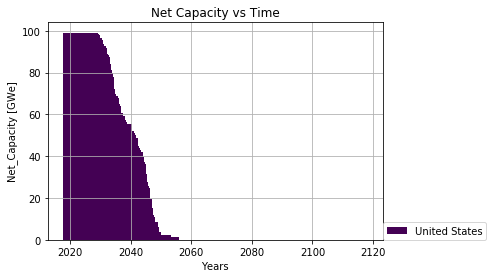

In [9]:
Image('power_plot.png')

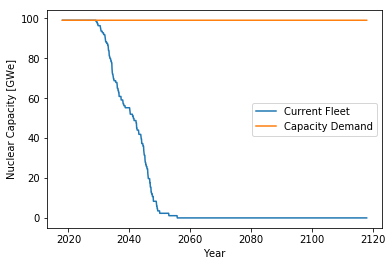

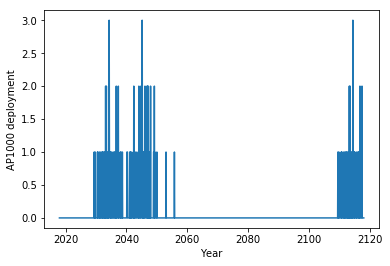

In [67]:
import copy
def maintain_power(growth_rate=0, new_lwr_life=80*12, new_lwr_power=1.11):
    name = 'maintain'
    cur = an.cursor('2018_us.sqlite')
    init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
    years = [init_year + x / 12 for x in timestep]
    power_dict = an.power_capacity(cur)
    power_dict = {k: np.array(v) for k, v in power_dict.items()}
    tot_pow_array = sum(power_dict.values())
    plt.plot(years[1:], tot_pow_array[1:], label='Current Fleet')
    demand_eq = '%s * (%s)**(t/12)' %(max(tot_pow_array), 1+growth_rate)
    demand_array = np.zeros(duration)    
    for indx, val in enumerate(timestep):
        t = val
        demand_array[indx] = eval(demand_eq)
    plt.plot(years, demand_array, label='Capacity Demand')
    lack_array = demand_array - tot_pow_array
    cur_lack_array = copy.deepcopy(lack_array)
    dep_array = np.zeros(duration)
    for indx, val in enumerate(lack_array):
        if indx == 0:
            continue
        if cur_lack_array[indx] > new_lwr_power:
            n_dep = cur_lack_array[indx] // new_lwr_power
            dep_array[indx] = n_dep
            cur_lack_array[indx:indx+new_lwr_life] -= n_dep * new_lwr_power
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Nuclear Capacity [GWe]')
    plt.show()
    plt.close()
    
    
    # use dep array to create new reactors
    plt.plot(years, dep_array)
    plt.xlabel('Year')
    plt.ylabel('AP1000 deployment')
    plt.show()
    plt.close()
    prototypes = ''
    lifetimes = ''
    n_build = ''
    build_times = ''
    for indx, val in enumerate(dep_array):
        if val != 0:
            prototypes += '<val>ap1000</val>\n' 
            lifetimes += '<val>%i</val>\n' %new_lwr_life
            n_build += '<val>%i</val>\n' %val
            build_times += '<val>%i</val>\n' %indx

    s = """
        <institution><name>future_lwrs</name>
        <config><DeployInst>
        <prototypes>
        %s
        </prototypes>
        <build_times>
        %s
        </build_times>
        <n_build>
        %s
        </n_build>
        <lifetimes>%s</lifetimes>
        </DeployInst></config></institution>""" %(prototypes, build_times, n_build, lifetimes)
    
    with open('2018_us.xml', 'r') as f:
        n = f.read()
    n = n.replace('<!-- deploy_scheme -->', s)
    with open('maintain.xml', 'w') as f:
        f.write(n)
    
    
maintain_power()



In [68]:
cur = an.cursor('maintain.sqlite')
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


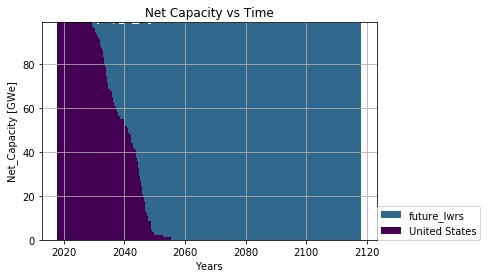

In [69]:
Image('power_plot.png')